# Predicting bulldozer seling

This notebook aims to predict future selling price of the bulldozers based on their technical parameters and time of sale for the ones sold so far.

## 1. Problem definition
> How well can the future sale price of the bulldozer be predicted given its characteristics and previous sales?
## 2. Data
The data is downloaded from the Kaggle "Blue book for buldozers" competition: https://www.kaggle.com/c/bluebook-for-bulldozers/overview
Looking at it, it is clear that the problem is a time series regression one.

There are 3 main datasets:
* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition (public now). It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition. (It's missing the Price column, since we aim to predict it in original competition).


## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well the model is doing, I'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

For this dataset, Kaggle provides a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) 

In [46]:
#Import the necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [47]:
# Importing the training and validation set for exploration

df=pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [48]:
# Dates not parsed properly, some data is missing
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [49]:
df.isna().sum() #Some features are missing most of the data

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

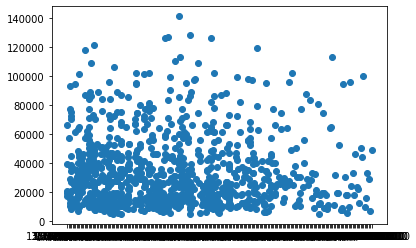

In [50]:
#Unparsed dates mess up x axis
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000],df.SalePrice[:1000])

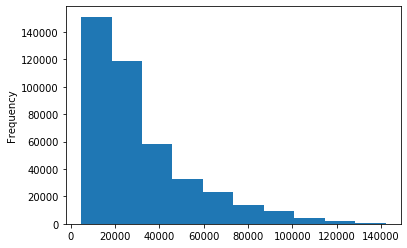

In [51]:
df.SalePrice.plot.hist()

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).  `parse_dates` parameter takes care of that.

In [52]:
df=pd.read_csv("data/TrainAndValid.csv", 
               low_memory=False, 
               parse_dates=["saledate"])

In [53]:
df.saledate.dtype

dtype('<M8[ns]')

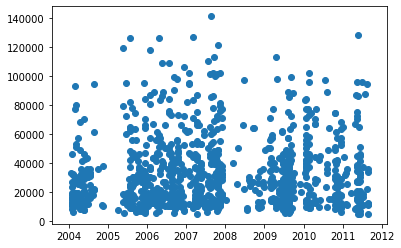

In [54]:
#Much better plot
fig, ax = plt.subplots() 
ax.scatter(df.saledate[:1000],df.SalePrice[:1000])

In [55]:
df.head().T #Let's explore all the features

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort by saledate

Good to do when working with time series, I want the past data to predict the future after all.

In [56]:
#Sort
df.sort_values(by=["saledate"], inplace=True, ascending = True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Making copy of the original data frame

We want the source intact so for now will work on the copy.

In [57]:
# Make a copy of the original dataframe to have the base data, just in case
df_tmp = df.copy()

### Extract additional parameters from `saledate` column

The day of the week or part of the month can provide useful information about the sales.

In [58]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [59]:
# Now can drop the saledate column
df_tmp.drop("saledate", axis = 1, inplace=True)

In [60]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling 

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html),  a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good model.

In [61]:
# And this will crash since there are missing values
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42) # max CPU scores and fixed seed

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice) #problem with types


ValueError: could not convert string to float: 'Low'

In [62]:
#Check for missing data again
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Fixing the data  - convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) can be used, which allows us to interact and manipulate the types of data.

In [63]:
pd.api.types.is_string_dtype(df_tmp)

False

In [64]:
# Find the columns with strings

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [65]:
# Turn string values into category values (a bitlike R factors)

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [66]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [67]:
df_tmp.state.cat.codes # categories still look like strings but have numeric value under the hood

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [68]:
df_tmp.isna().sum()/len(df_tmp) # missing values stll present

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [69]:
df_tmp.to_csv("data/train_tmp.csv", index=False)

## Filling missing values
### Numeric values first

Filling any missing values in the column with median of that column

In [70]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [71]:
# Check which numeric columns have missing values

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        

auctioneerID
MachineHoursCurrentMeter


In [72]:
# Fill with median and add a label to show whether the data was missing originally to retain that information
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_tmp[label+"_is_missing"] = pd.isnull(content)  # was missing?
            df_tmp[label] = content.fillna(content.median()) # filling missing, meadian more robust for outliers
        

In [73]:
# Check again, no missing values this time.
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        

In [74]:
df_tmp.auctioneerID_is_missing.value_counts() #Check the count of initially missing values

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [75]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

Now the same trick with categorical variables, as well as changing them into numbers.

In [76]:
for label, content in df_tmp.items():
        if not pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [77]:
# Turn categorical values into numbers and fill missing

for label, content in df_tmp.items():
        if not pd.api.types.is_numeric_dtype(content): #columns which are not numeric
            df_tmp[label+"_is_missing"] = pd.isnull(content) # Add the binary column indicating missing values
            df_tmp[label] = pd.Categorical(content).codes + 1  #Turn categories into numbers and add 1 because NaN is -1

In [78]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [79]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 81.1 MB


In [80]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Let's reinitialize the RandomForestRegressor()

In [81]:
%%time
model = RandomForestRegressor(n_jobs=-1 , random_state=42)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

Wall time: 4min 30s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [82]:
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970563

** That is messed up - no train test split **
### Splitting data into train/valid sets

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.

This makes sense since it is a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting the data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, splitting our data into training, validation and test sets using the date each sample occured is a valid method.

In this case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

In [83]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [84]:
X_train, y_train  = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_val, y_val  = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Custom scoring parameter

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

Since Scikit-Learn doesn't have a function built-in for RMSLE, I'll create my own.

It can be done by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

I'll also calculate the MAE and R^2 for fun.

In [85]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Function calculating Root Mean Squared Log Error
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))
# Create function to evaluate a few metrics of the model

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Validation MAE": mean_absolute_error(y_val, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Validation RMSLE": rmsle(y_val, val_preds),
             "Training R2": r2_score(y_train, train_preds),
             "Validation R2": r2_score(y_val, val_preds),}
    return scores

## Testing the model on subset (to tune hyperparameters)

In [86]:
# Too long since there are over 400k entries in training set

#%%time 
#model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [88]:
%%time
#Let's work on a 10000 samples subset first
#Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(X_train, y_train)

Wall time: 9.57 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [89]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Validation MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Validation RMSLE': 0.29362638671089003,
 'Training R2': 0.8606658995199189,
 'Validation R2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

I can increase n_iter to try more combinations of hyperparameters but in this case, I'll try the value of 20 to save time and see where it gets us.


In [90]:
%%time

from sklearn.model_selection import RandomizedSearchCV

grid_rs = {
    "n_estimators": np.arange(10,100,10),
    "max_depth": [None, 3,5,10],
    "min_samples_split": np.arange(2,20,2),
    "min_samples_leaf": np.arange(1,20,2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
    
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                                                param_distributions = grid_rs,
                                                   n_iter=20,
                                                   cv=5,
                                                   verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


Wall time: 6min 9s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [91]:
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [92]:
show_scores(rs_model)

{'Training MAE': 6565.299226260176,
 'Validation MAE': 7953.3679880666605,
 'Training RMSLE': 0.2940294334722834,
 'Validation RMSLE': 0.31725566197824545,
 'Training R2': 0.8115665126037817,
 'Validation R2': 0.7903040471996796}

### Train the model with the best hyperparameters - 100 iters

In a model prepared earlier, 100 different combinations of hyperparameters were tried (setting `n_iter` to 100 in `RandomizedSearchCV`) and the best results came from the ones you see below.


I'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [93]:
%%time

#Best parameters on the full set

ideal_model = RandomForestRegressor(
    n_estimators = 40,
    min_samples_leaf = 1,
    min_samples_split=14,
    max_features = 0.5,
    n_jobs=-1,
    max_samples=None,
    random_state=42
)

ideal_model.fit(X_train, y_train)

Wall time: 46.1 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [94]:
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Validation MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Validation RMSLE': 0.24524163989538328,
 'Training R2': 0.9588145522577225,
 'Validation R2': 0.8818019502450094}

## Make predictions on test data


In [95]:
df_test = pd.read_csv("data/Test.csv", low_memory = False, parse_dates=["saledate"])

In [96]:
test_preds = ideal_model.predict(df_test) # Change data to numbers again

ValueError: could not convert string to float: 'Low'

In [97]:
#Preprocessing the data
# make a function for that

def preprocess_data(df):
    """
    Changes the data to a proper format
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    df.drop("saledate", axis = 1, inplace=True)
    
    # Fill numerics with medians
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)  # was missing?
                df[label] = content.fillna(content.median())
            
    #Change categorical and fill them
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
            
            
    return df

In [98]:
df_test = preprocess_data(df_test)
df_test.head()
#DIfferent number of columns between test and train datasets

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [1]:
# Check the columns using sets

set(X_train.columns) - set(df_test.columns)

NameError: name 'X_train' is not defined

In [100]:
# Manually adjust the test set by adding missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [101]:
# Make predictions using the best model
test_preds = ideal_model.predict(df_test)

In [102]:
# Format predictions properly
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [103]:
df_preds.to_csv("data/test_preds.csv", index=False)

## Feature importance

Since the model is able to make predictions, it might be curious to see what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In this case, after the model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Let's check it out.

In [104]:
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [105]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features":columns, "feature_importances":importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_ylabel("Feature importance")
    ax.invert_yaxis()

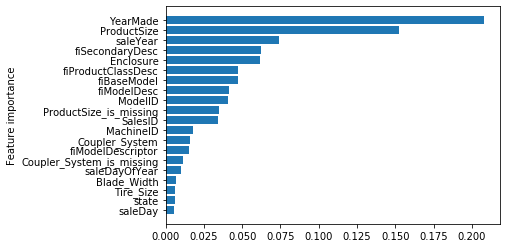

In [106]:
plot_features(X_train.columns, ideal_model.feature_importances_)